In [5]:
import tensorflow
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [6]:
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D

def text_detection_model(channels=8):
    """ Defines a simple CNN that inputs an image and outputs a binary mask. """

    input_shape = (1, None, None)
    activation = 'relu'

    model = Sequential()
    model.add(Convolution2D(channels, 5, 5, border_mode='same', input_shape=input_shape))
    model.add(Activation(activation))
    model.add(Convolution2D(channels, 5, 5, border_mode='same'))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(channels, 5, 5, border_mode='same'))
    model.add(Activation(activation))
    model.add(Convolution2D(channels * 2, 5, 5, border_mode='same'))
    model.add(Activation(activation))
    model.add(Convolution2D(channels * 2, 5, 5, border_mode='same'))
    model.add(Activation(activation))
    model.add(Convolution2D(256, 1, 1, border_mode='same'))
    model.add(Activation(activation))
    model.add(Convolution2D(1, 1, 1, border_mode='same'))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model


In [7]:
model = text_detection_model()

In [8]:
import random

def credit_card_number():
    return ' '.join(['{0:04d}'.format(random.randint(0, 9999)) for _ in range(4)])
    
credit_card_number()  

'7512 7440 3873 3310'

In [34]:
import glob
import sys
import numpy as np
import scipy.ndimage
from PIL import Image, ImageFont, ImageDraw
from image import normalize_pixels

def load_fonts(folder, font_size=24):
    font_files = glob.iglob('%s/*.ttf' % folder)
    fonts = [ImageFont.truetype(font_file, font_size) for font_file in font_files]
    return fonts

def load_backgrounds(folder):
    image_files = glob.iglob('{}/*.jpg'.format(folder))
    backgrounds = [scipy.ndimage.imread(image_file, flatten=True) for image_file in image_files]
    return backgrounds

def rotate_image(image, rotation_sigma=15):
    angle = 0
    if rotation_sigma > 0 and np.random.rand() > 0.1:
        angle = np.random.randn() * rotation_sigma
        if abs(angle) > 0.1:
            image = scipy.ndimage.interpolation.rotate(image, angle=angle, order=1, mode='constant', cval=0)
            image[image < 0.05] = 0
    return image, angle

def credit_card_image(number_string, fonts, backgrounds=None, image_size=(160, 160), image_padding=20):
    
    font = random.choice(fonts)
    
    text_image = Image.new('F', (image_size[0] + image_padding * 2, 
                                 image_size[1] + image_padding * 2), color=0)
    
    draw = ImageDraw.Draw(text_image)
    
    text_position = (np.random.randint(-image_size[0], image_size[0]),
                     np.random.randint(-image_size[1], image_size[1]))
    
    draw.text(text_position, number_string, 1, font=font)
    text_image = np.array(text_image, dtype=np.float32)
    text_image, angle = rotate_image(text_image)
    text_image = text_image[image_padding:text_image.shape[0] - image_padding,
                            image_padding:text_image.shape[1] - image_padding]
    
    
    image = text_image.copy()
    image += np.random.normal(size=text_image.shape) * 0.05
    image = normalize_pixels(image, invert=False) 
    
    mask = text_image > 0.25
    text_image[mask] = 1
    text_image[np.logical_not(mask)] = 0
    
    return image, text_image
    

In [35]:
fonts = load_fonts('fonts')
print(fonts)

[<PIL.ImageFont.FreeTypeFont object at 0x118d7ff98>, <PIL.ImageFont.FreeTypeFont object at 0x1190bfcf8>]


In [36]:
cc_number = credit_card_number()
print(cc_number)
image, target = credit_card_image(cc_number, fonts=fonts)

5368 3670 0278 3447


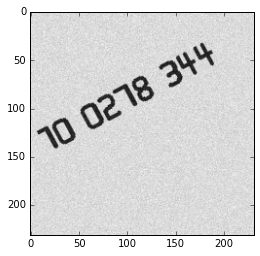

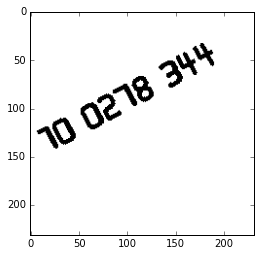

In [37]:
plt.figure()
plt.imshow(image, cmap=plt.cm.gray_r, interpolation='bilinear')
plt.figure()
plt.imshow(target, cmap=plt.cm.gray_r, interpolation='bilinear')